In [2]:
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os
import sys

In [155]:
def readxml(separately=False):
    """
    separately=True: 分开读取数据
    return: (train_dataset, train_labels), (test_dataset, test_labels)
    data.shape: 文件数：5， 每个文件笔迹数：20，每个笔迹点数：47..，每个点的信息:(x,y,t）
    labels.shape: (5, 20, 47...)
    """
    path = "./project2-data/"
    files = os.listdir(path)
    xmls = [ET.ElementTree(file=path+f) for f in files]
    roots = [xml.getroot() for xml in xmls]
    dataset = [[[list(coord.attrib.values()) for coord in example] for example in root[1:]] for root in roots]
    labels = [[i for _ in range(len(dataset[i]))] for i in range(len(dataset))]
    # 五个文件分开读取，主要用这个部分
    if separately:
        # 文件数：5， 每个文件笔迹数：20，每个笔迹点数：47个等，每个点的信息：（x,y,t）
        train_dataset = [[np.asfarray(exam) for exam in data[1::2]] for data in dataset]
        train_labels = [np.array(label[1::2]) for label in labels]
        test_dataset = [[np.asfarray(exam) for exam in data[::2]] for data in dataset]
        test_labels = [np.array(label[::2]) for label in labels]
    else:
        # 所有点展开成全部数据
        dataset = [sum(data, []) for data in dataset]
        train_dataset = sum([data[1::2] for data in dataset], [])
        train_labels = sum([label[1::2] for label in labels], [])
        test_dataset = sum([data[::2] for data in dataset], [])
        test_labels = sum([label[::2] for label in labels], [])
        train_dataset = np.asfarray(train_dataset)
        test_dataset = np.asfarray(test_dataset)
        train_labels = np.array(train_labels)
        test_labels = np.array(test_labels)
    return (train_dataset, train_labels), (test_dataset, test_labels)

def KMeans(dataset, k):
    """
    dataset: (len, 2)
    return: idx, centroids, distance
            聚类索引，质心，距离
    """
    dim = dataset.shape[1]  # 2维
    idx, centroids, distance = np.zeros((3, len(dataset)))

    # 取随机k个质心, shape: (质心数=k，维数=2)
    lows = np.min(dataset, axis=0)
    highs = np.max(dataset, axis=0)
    centroids = [np.random.uniform(low, high, (k, )) for low, high in zip(lows, highs)]
    centroids = np.array(centroids).T

    # 假设初始类别都为第一类
    distances = np.zeros((dataset.shape[0], k))
    idx = np.zeros((dataset.shape[0]))
    while True:
        # 距离，shape(数据点数=num，每个点对应的k个距离=k)
        # 计算每点到其他所有质心的距离
        # 把质心按照到原点的距离排序
#         c_dist = np.linalg.norm(centroids, axis=1)
#         c_idx = np.argsort(c_dist)
#         centroids = centroids[c_idx, :]
        for i, centroid in enumerate(centroids):
            distances[:, i] = np.linalg.norm(dataset - centroid, axis=1)
        # 每个点最小的到某一质心距离，距离最小的质心作为类别
        new_idx = np.argmin(distances, axis=1)
        # 更新质心
        old_centroids = centroids.copy()
        temp = [dataset[np.where(new_idx==i)] for i in range(k)]
        # 处理空簇
        for i in range(k):
            if temp[i].size == 0: # 出现空簇，则重新设定质心
                centroids[i] = np.mean(centroids, axis=0)
            else:
                centroids[i] = np.mean(temp[i], axis=0)
        # 计算变化率
        change = np.count_nonzero(old_centroids-centroids)
        # print(old_centroids - centroids)
        idx = new_idx
        # print(change)
        if change == 0:
            break
    return idx, centroids, np.max(distances, axis=1)

def show_kmeans(coords, centroids, idx):
    """显示聚类结果"""
    plt.figure(figsize=(16, 12))
    for i in range(len(centroids)):
        add = np.where(idx == i)
        show_coords = coords[add, :][0]
        plt.scatter(show_coords[:, 0], show_coords[:, 1], label=str(i))
        plt.scatter(centroids[i][0], centroids[i][1], s=500, c='black')
        plt.legend()

In [156]:
class HMM():

    def __init__(self, A=None, B=None, pi=None):
        if A is not None: 
            self.A = np.array(A)        # (N, N）
            self.N = A.shape[0]         # states
            self.Q = list(range(self.N))
        if B is not None: 
            self.B = np.array(B)        # (N, M)
            self.M = B.shape[1]         # obs
            self.V = list(range(self.M))
        if pi is not None:
            self.pi = np.array(pi).reshape(self.N, )

    def predict(self, obs_seqs, labels=None):
        """
        对obs_seqs中的每个观测序列，使用前向算法计算其出现的概率
        取对数
        """
        probs = []
        for obs_seq in obs_seqs:
            polambda, _ = self.forward(obs_seq)
            # log-likelyhood
            polambda = np.log2(polambda)
            probs.append(polambda)
        return np.array(probs)
    
    def learn(self, obs_seqs, iteration=None, criterion=5e-2):
        """
        从obs_seqs中学习ABpi参数
        obs_seqs: 多条观测序列
        iteration: 迭代次数
        criterion: 变动的误差，判断是否收敛
        """
        use_iter = False
        # 是否使用变量直接控制迭代次数
        if iteration is not None:
            use_iter = True
        count = 0
        while True:
            old_A, old_B, old_pi = self.A.copy(), self.B.copy(), self.pi.copy()
            # 使用 baum_welch 算法学习参数
            self.baum_welch_multi_seq(obs_seqs)
            count += 1
            # ABpi中出现nan值，就退出循环
            if np.isnan(self.A).any() or np.isnan(self.B).any() or np.isnan(self.pi).any():
                self.A, self.B, self.pi = old_A, old_B, old_pi
                break
            if use_iter:
                # 迭代次数达到上限iteration，退出循环
                if count >= iteration: break
            else:
                # 如果ABpi的变动小于criterion，就退出循环
                if np.sum(abs(old_A - self.A)) <= criterion and \
                    np.sum(abs(old_B - self.B)) <= criterion and \
                    np.sum(abs(old_pi - self.pi)) <= criterion:
                    break
        print("baul_welch_iterations:", count)
        return self.A, self.B, self.pi

    def forward(self, obs_seq):
        """
        前向算法
        param: observation sequence
        return: P(O|lambda), alpha
        """
        T = np.array(obs_seq).size
        alpha = np.zeros((T, self.N))
        # 数组运算代替循环，递推
        alpha[0, :] = self.pi * self.B[:, obs_seq[0]]
        for t in range(T-1):
            # 对T求和
            alpha[t+1, :] = self.B[:, obs_seq[t+1]] * (alpha[t, :].dot(self.A))
        polambda = np.sum(alpha[T-1, :])
        return polambda, alpha
    
    def backward(self, obs_seq):
        """
        后向算法
        return: P(O|lambda), beta
        """
        T = np.array(obs_seq).size
        beta = np.zeros((T, self.N))
        beta[T-1, :] = 1
        for t in range(T-2, -1, -1):
            beta[t, :] =  self.A.dot(self.B[:, obs_seq[t+1]]*beta[t+1, :]) 
        polambda = np.sum(self.pi * self.B[:, obs_seq[0]] * beta[0, :])
        return polambda, beta

    def gamma_xi(self, obs_seq):
        """
        按照公式计算obs_seq的gamma和xi
        return: gamma, xi
        """
        # 获得概率，和alpha, beta
        f_p, alpha = self.forward(obs_seq)
        b_p, beta = self.backward(obs_seq)
        T = np.array(obs_seq).size
        gamma = np.zeros((T, self.N))
        xi = np.zeros((T, self.N, self.N))
        # 计算gamma和xi
        for t in range(T):
            gamma[t, :] = alpha[t, :] * beta[t, :] / f_p
        for t in range(T-1):
            xi[t, :, :] = alpha[t:t+1, :].T.dot(beta[t+1:t+2, :]*self.B[:, obs_seq[t+1]]) * self.A 
            xi[t, :, :] /= b_p
        return gamma, xi

    def baum_welch_multi_seq(self, obs_seqs):
        """
        根据多观测序列更新参数ABpi，直接更改对象的参数，无需返回
        return: A, B, pi
        """
        obs_seqs =[np.array(obs_seq) for obs_seq in obs_seqs]
        # 求取观测序列对应的gamma和xi
        gam_xi = [self.gamma_xi(obs_seq) for obs_seq in obs_seqs]
        gammas = [item[0] for item in gam_xi]
        xis = [item[1] for item in gam_xi]
        # 更新pi
        self.pi = np.mean([gamma[0, :] for gamma in gammas], axis=0)
        # 更新B
        # B的分母
        denominator = sum([np.sum(gamma, axis=0, keepdims=True).T for gamma in gammas])
        # B的分子
        numerator = np.zeros(self.B.shape)
        for obs_seq, gamma in zip(obs_seqs, gammas):
            B = self.B.copy()
            for k, v in enumerate(self.V):
                idx = np.where(obs_seq == v)[0]
                B[:, k] = np.sum(gamma[idx, :], axis=0)
            numerator += B
        self.B = numerator / denominator
        # 利用公式更新Ａ
        # A的分母
        denominator = sum([np.sum(gamma[:-1], axis=0, keepdims=True).T for gamma in gammas])
        # A的分子
        numerator = sum([np.sum(xi[:-1], axis=0) for xi in xis])
        self.A = numerator / denominator
        return self.A, self.B, self.pi

    def viterbi(self, obs_seq):
        """
        维特比算法, 根据ABpi和obs_seq计算最有可能对应的隐状态序列
        return: 最优隐状态序列 I
        """
        # 初始化
        obs_seq = np.array(obs_seq)
        T = obs_seq.size
        delta = np.zeros((T, self.N))
        psi = np.zeros((T, self.N))
        delta[0, :] = self.pi * self.B[:, obs_seq[0]]
        # 递推
        for t in range(1, T):
            d_t_j = delta[t-1:t, :] * self.A.T
            delta[t, :] = self.B[:, obs_seq[t]] * np.max(d_t_j, axis=1)
            psi[t, :] = np.argmax(d_t_j, axis=1)
        # 终止
        P = np.max(delta[T-1, :])
        I= np.zeros((T, ), dtype=np.int)
        I[T-1] = np.argmax(delta[T-1, :])
        # 回溯, 倒数第二个到第一个
        for t in range(T-2, -1, -1):
            I[t] = psi[t+1, I[t+1]]
        return np.reshape(I, (I.size, 1)), P

In [157]:
def run(N, M, iter=None):
    """
    N: 隐状态个数
    M: 观测状态个数
    """
    (train_dataset, train_labels), (test_dataset, test_labels)= readxml(True)
    # 把每个文件的coords分到一块
    all_data = [train+test for train, test in zip(train_dataset, test_dataset)]
    coords = [np.concatenate(data)[:, :2] for data in all_data]
    idx_5 = [KMeans(coord, M)[0] for coord in coords]
    train_size = [len(np.concatenate(data)) for data in train_dataset]
    train_idx_5 = [idx[: train_size[i]] for i, idx in enumerate(idx_5)]
    test_idx_5 = [idx[train_size[i]: ] for i, idx in enumerate(idx_5)]

    # # 聚完类再分开
    train_length = [[len(data[i]) for i in range(len(data))] for data in train_dataset]
    train_length = [[sum(l[:i]) for i in range(len(l))]+[sum(l)] for l in train_length]
    # # (字母种类，每种多少个笔迹，每个笔迹多少个点)
    obs_seqs_5 = [[train_idx_5[j][l[i]:l[i+1]] for i in range(len(l)-1)] for j, l in enumerate(train_length)]
    
    test_length = [[len(data[i]) for i in range(len(data))] for data in test_dataset]
    test_length = [[sum(l[:i]) for i in range(len(l))]+[sum(l)] for l in test_length]
    test_obs_seqs_5 = [[test_idx_5[j][l[i]:l[i+1]] for i in range(len(l)-1)] for j, l in enumerate(test_length)]
    
    cate = ['a', 'e', 'i', 'o', 'u']
    hmms = []
    for i in range(5):
            # 随机初值
            A = np.random.rand(N, N)
            A /= np.sum(A, axis=1, keepdims=True)
            B = np.random.rand(N, M)
            B /= np.sum(B, axis=1, keepdims=True)
            pi = np.random.rand(N)
            pi /= np.sum(pi) 
            hmm = HMM(A, B, pi)
            # baum welch学习算法
            hmm.learn(obs_seqs_5[i], iter)
            hmms.append(hmm)

    # 对于每个字母
    confusion_mat = np.zeros((5, 5))
    for i, test_obs_seqs in enumerate(test_obs_seqs_5):
        # 求对于5个hmm出现的概率
        probs = np.array([hmm.predict(test_obs_seqs) for hmm in hmms])
        idx = np.argmax(probs, axis=0)
        # 求取混淆矩阵
        for j in range(5):
            confusion_mat[i][j] = len(np.where(idx==j)[0])
    # 百分比
    confusion_mat /= np.sum(confusion_mat, axis=0, keepdims=True)
    confusion_mat = np.around(confusion_mat, 2)
    return confusion_mat

In [168]:
class DTW_Classifier():
    """DTW"""

    def fit(self, train_seqs, train_labels):
        """存储训练数据和训练标签"""
        self.train_seqs = np.array(train_seqs).copy()
        self.train_labels = np.array(train_labels).copy()
        self.cete = list(set(train_labels))

    def predict(self, test_seqs, test_labels):
        """
        预测测试数据
        return: 混淆矩阵，误分率
        """
        dtws = []
        # 计算每个测试数据与所有训练数据的相似程度
        for i, test_seq in enumerate(test_seqs):
            dtw = []
            for train_seq in self.train_seqs:
                dtw.append(self.cal(test_seq, train_seq))
            dtws.append(dtw)
            if i % 10 == 0: print(i+10, "个测试数据已预测")
        dtws = np.array(dtws)
        # 选择最相似的那个训练数据对应的类别 为预测的类别
        min_dist_idx = np.argmin(dtws, axis=1).flatten()
        res = self.train_labels[min_dist_idx]
        # 计算误判率
        dif = test_labels - res
        mis = np.count_nonzero(dif) / dif.size
        # 计算混淆矩阵
        confusion_mat = np.zeros((5, 5))
        for i in range(5):
            for j in range(5):
                confusion_mat[i][j] = len(np.where(res[i*20:(i+1)*20]==j)[0])
        # 百分比
        confusion_mat /= np.sum(confusion_mat, axis=0, keepdims=True)
        confusion_mat = np.around(confusion_mat, 2)
        return confusion_mat, mis

    def cal(self, seq1, seq2):
        """
        计算两个序列seq1, seq2的相似程度
        return: 相似程度
        """
        n, m = len(seq1), len(seq2)
        dist = np.array([np.linalg.norm(seq2-s, axis=1) for s in seq1])
        dp = np.zeros((n+1 ,m+1))
        # 动态规划初始化, 第一行第一列初始化最大值，便于后面统一处理
        dp[:, 0] = sys.maxsize
        dp[0, :] = sys.maxsize
        dp[0, 0] = 0
        for i in range(1, n+1):
            for j in range(1, m+1):
                # 递推
                dp[i, j] = dist[i-1, j-1] + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])
        return dp[n, m]

### 训练数据和测试数据分开聚类

训练数据 [5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5
 5 5] ...
测试数据 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5] ...


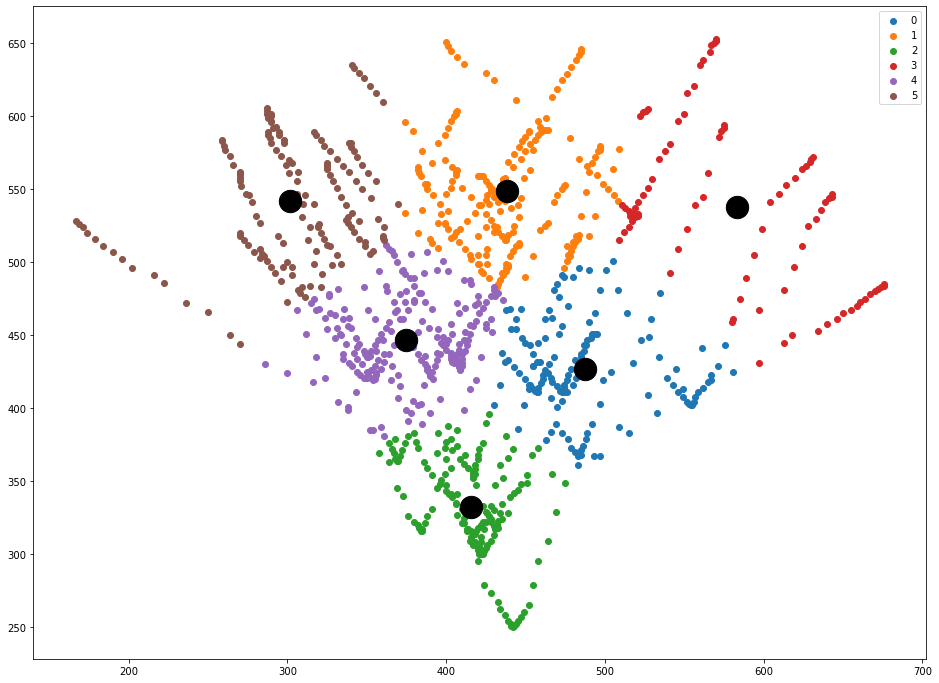

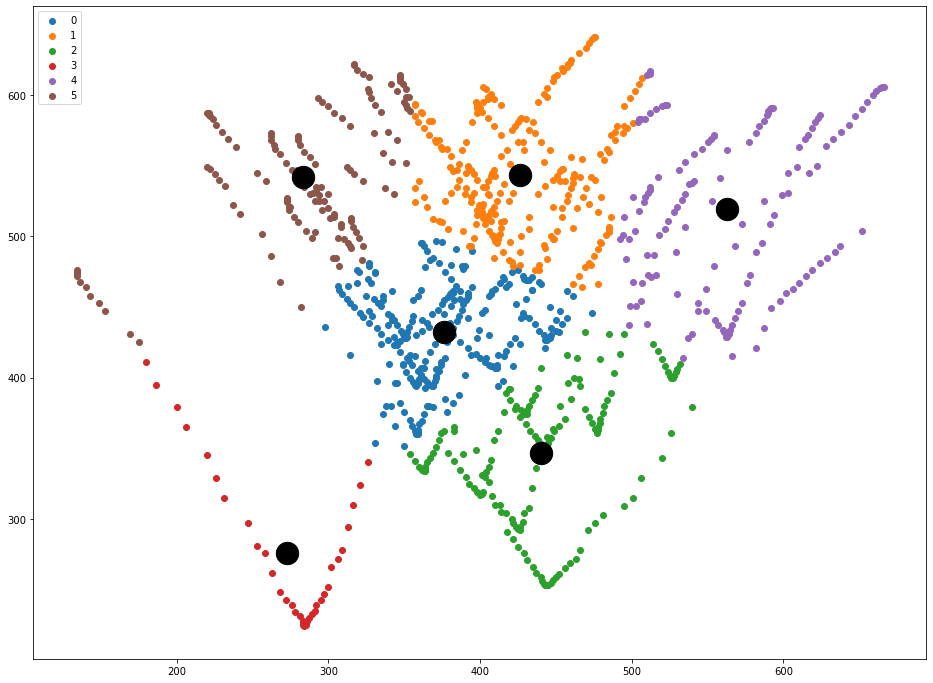

In [159]:
(train_dataset, train_labels), (test_dataset, test_labels)= readxml(True)
M = 6 # 6类

# 训练数据聚类
train_coords = [np.concatenate(data)[:, :2] for data in train_dataset]
KMeans_5 = [KMeans(coords, M) for coords in train_coords]

# # 测试数据聚类
test_coords = [np.concatenate(data)[:, :2] for data in test_dataset]
test_KMeans_5 = [KMeans(coords, M) for coords in test_coords]

show_kmeans(train_coords[0], KMeans_5[0][1], KMeans_5[0][0])
print("训练数据", KMeans_5[0][0][:150], "...")
show_kmeans(test_coords[0], test_KMeans_5[0][1], test_KMeans_5[0][0])
print("测试数据", test_KMeans_5[0][0][:150], "...")

 ### 训练数据和测试数据一起聚类

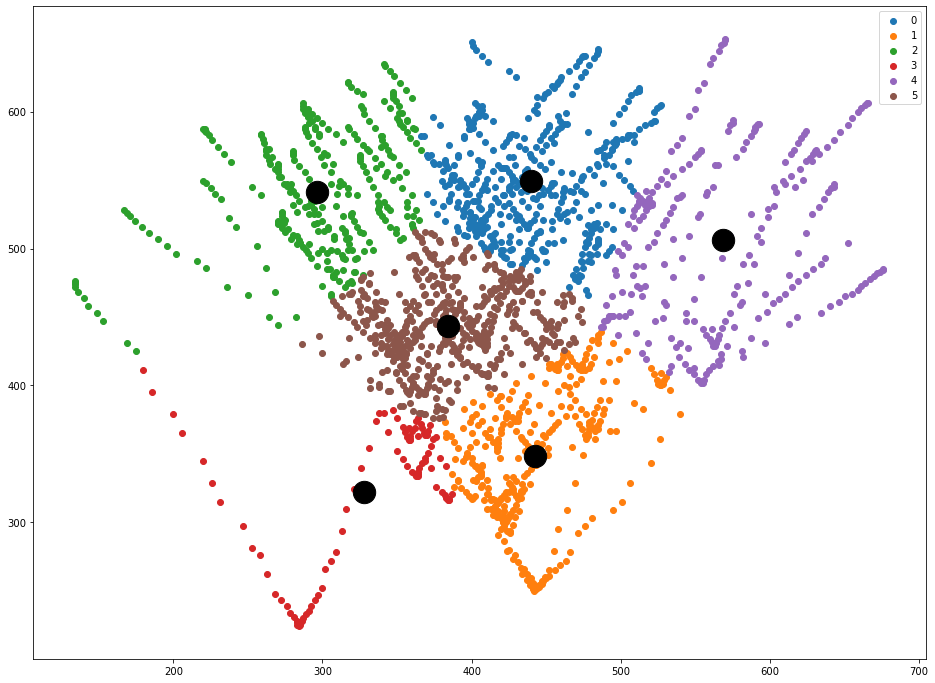

In [160]:
(train_dataset, train_labels), (test_dataset, test_labels)= readxml(True)
dataset = np.array([train+test for train, test in zip(train_dataset, test_dataset)])
all_coords = [np.concatenate(data)[:, :2] for data in dataset]
all_KMeans_5 = [KMeans(coords, M) for coords in all_coords]
show_kmeans(all_coords[0], all_KMeans_5[0][1], all_KMeans_5[0][0])

### 5个HMM分别判定

In [161]:
N = [5, 5, 5, 8, 10, 12]
M = [8, 10, 12, 5, 5, 5]
for i, (n, m) in enumerate(zip(N, M)):
    print("N=", N[i], "M=", M[i])
    confusion_matrix = run(n, m)
    mis = 1- np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print("misclassification:", mis)
    print("confusion matrix(百分比):")
    print(confusion_matrix)
    print()

N= 5 M= 8
baul_welch_iterations: 9
baul_welch_iterations: 28
baul_welch_iterations: 21
baul_welch_iterations: 12
baul_welch_iterations: 24
misclassification: 0.10999999999999999
confusion matrix(百分比):
[[0.88 0.   0.   0.16 0.1 ]
 [0.   0.95 0.   0.08 0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.12 0.   0.   0.72 0.  ]
 [0.   0.05 0.   0.04 0.9 ]]

N= 5 M= 10
baul_welch_iterations: 17
baul_welch_iterations: 15
baul_welch_iterations: 21
baul_welch_iterations: 14
baul_welch_iterations: 11
misclassification: 0.19161676646706582
confusion matrix(百分比):
[[0.65 0.   0.   0.1  0.22]
 [0.05 0.85 0.   0.   0.09]
 [0.   0.15 1.   0.   0.  ]
 [0.15 0.   0.   0.85 0.  ]
 [0.15 0.   0.   0.05 0.7 ]]

N= 5 M= 12
baul_welch_iterations: 11
baul_welch_iterations: 16
baul_welch_iterations: 25
baul_welch_iterations: 10
baul_welch_iterations: 10
misclassification: 0.19839679358717444
confusion matrix(百分比):
[[0.71 0.14 0.   0.   0.  ]
 [0.12 0.71 0.06 0.07 0.  ]
 [0.   0.   0.94 0.2  0.  ]
 [0.17 0.14 0.   0.73 0.0

### Option1 Dynamic Time Wrap

In [162]:
(train_dataset, train_labels), (test_dataset, test_labels)= readxml(True)
train_coords = [[exam[:, :2] for exam in data] for data in train_dataset]
train_coords = sum(train_coords, [])
train_labels = np.concatenate(train_labels)
test_coords = [[exam[:, :2] for exam in data] for data in test_dataset]
# (笔迹数100, 每个笔迹点数47, 数据维度2（x,y）)
test_coords = sum(test_coords, [])
test_labels = np.concatenate(test_labels)

In [169]:
dtw = DTW_Classifier()
dtw.fit(train_coords, train_labels)
confusion_matrix, mis = dtw.predict(test_coords, test_labels)
print("confusion_matrix（百分比）:")
print(confusion_matrix)
print("misclassification:", mis)

10 个测试数据已预测
20 个测试数据已预测
30 个测试数据已预测
40 个测试数据已预测
50 个测试数据已预测
60 个测试数据已预测
70 个测试数据已预测
80 个测试数据已预测
90 个测试数据已预测
100 个测试数据已预测
confusion_matrix（百分比）:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
misclassification: 0.0


### Option2 Viterbi (One HMM)

In [170]:
def option_2(N, M, iter=None):
    # 读取数据
    (train_dataset, train_labels), (test_dataset, test_labels)= readxml(True)
    train_coords = [[exam[:, :2] for exam in data] for data in train_dataset]
    train_coords = sum(train_coords, [])
    train_labels = np.concatenate(train_labels)
    test_coords = [[exam[:, :2] for exam in data] for data in test_dataset]
    # (笔迹数100, 每个笔迹点数47..., 数据维度2（x,y）)
    test_coords = sum(test_coords, [])
    test_labels = np.concatenate(test_labels)
    # 所有数据放在一起聚类
    res = KMeans(np.concatenate(train_coords + test_coords), M)
    # 按训练数据和测试数据划分聚类好的数据
    train_length = [len(coord) for coord in train_coords]
    test_length = [len(coord) for coord in test_coords]
    # starts
    ss = [sum(train_length[:i]) for i in range(len(train_coords))]
    # ends
    es = [sum(train_length[:i+1])-1 for i in range(len(train_coords))]
    train_obs_seqs = [res[0][:sum(train_length)][s:e] for s, e in zip(ss, es)]
    ss = [sum(test_length[:i]) for i in range(len(test_coords))]
    es = [sum(test_length[:i+1])-1 for i in range(len(test_coords))]
    test_obs_seqs = [res[0][sum(train_length):][s:e] for s, e in zip(ss, es)]
    # 建立HMM
    A = np.random.rand(N, N)
    A /= np.sum(A, axis=1, keepdims=True)
    B = np.random.rand(N, M)
    B /= np.sum(B, axis=1, keepdims=True)
    pi = np.random.rand(N)
    pi /= np.sum(pi) 
    hmm = HMM(A, B, pi)
    # 利用训练数据学习ABpi参数
    hmm.learn(train_obs_seqs, iter)
    # 利用维特比算法求出最有可能出现的隐状态序列，分别求出训练数据和测试数据的隐状态序列
    train_hid = [hmm.viterbi(obs)[0] for obs in train_obs_seqs]
    test_hid = [hmm.viterbi(obs)[0] for obs in test_obs_seqs]
    # 利用 DTW 求取隐状态之间的相似度，并分类
    dc = DTW_Classifier()
    dc.fit(train_hid, train_labels)
    return dc.predict(test_hid, test_labels)

In [172]:
confusion_mat, mis = option_2(6, 6)
# 百分比
confusion_mat /= np.sum(confusion_mat, axis=0, keepdims=True)
confusion_matrix = np.around(confusion_mat, 2)
print("confusion_matrix（百分比）:")
print(confusion_matrix)
print("misclassification:", mis)

baul_welch_iterations: 10
10 个测试数据已预测
20 个测试数据已预测
30 个测试数据已预测
40 个测试数据已预测
50 个测试数据已预测
60 个测试数据已预测
70 个测试数据已预测
80 个测试数据已预测
90 个测试数据已预测
100 个测试数据已预测
confusion_matrix（百分比）:
[[1.   0.   0.   0.   0.04]
 [0.   0.95 0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.05 0.   1.   0.12]
 [0.   0.   0.   0.   0.84]]
misclassification: 0.05
